In [3]:
import logging

import matplotlib.pyplot as plt

from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidnoiseanalysis import plot_psd
from mkidreadoutanalysis.mkidreadout import MKIDReadout
from mkidreadoutanalysis.optimal_filters.make_filters import Calculator
from mkidcore.config import ConfigThing
import copy
%matplotlib inline

In [4]:
blue_data = np.zeros((3,2**19*50))
for i in range(0,50):
    data = np.load(f'/work/rfsocs/jenny_r_data/wf_ellison3_6000_760GHz_blue{i:02d}.npz')
    blue_data[0,i*2**19:(i+1)*2**19] = data['phase_light']
    blue_data[1,i*2**19:(i+1)*2**19] = data['iq_light'].real
    blue_data[2,i*2**19:(i+1)*2**19] = data['iq_light'].imag


22381


0.2465631406162123


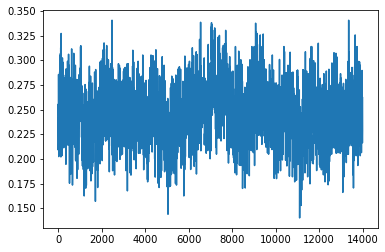

In [5]:
dark_data = np.zeros((3,2**19*50))
for i in range(0,50):
    data = np.load(f'/Users/jpsmith/jenny_r_data/wf_ellison3_6000_760GHz_dark2{i:02d}.npz')
    dark_data[0,i*2**19:(i+1)*2**19] = data['phase_dark']
    dark_data[1,i*2**19:(i+1)*2**19] = data['iq_dark'].real
    dark_data[2,i*2**19:(i+1)*2**19] = data['iq_dark'].imag

In [6]:
phase_dark = dark_data[0,:]

In [7]:
phase_data = -blue_data[0,:]

23551


0.2554050852556361


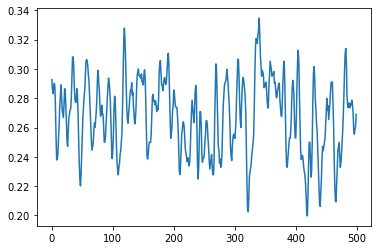

In [8]:
plt.plot(phase_dark[40000:100000])
plt.plot(phase_data[40000:100000])

In [9]:
(phase_data<-0.2).sum()

In [10]:
cfg=ConfigThing()
cfg.registerfromkvlist((('dt', 1e-6),
('fit', True),
('summary_plot', True),
('pulses.unwrap', False),
('pulses.fallback_template', 'default'),
('pulses.ntemplate', 1000), # need to set this larger to calculate covariance matrix in the time domain "accurately" for the number of selected filter coefficients
('pulses.offset', 20),
('pulses.threshold', 6),
('pulses.separation', 40),
('pulses.min_pulses', 1000),
('noise.nwindow', 1000), #1000
('noise.isolation', 100),
('noise.max_windows', 2000), # maximum number of nwindows of samples needed before moving on [int]
('noise.max_noise', 5000), #2000
('template.percent', 80),
('template.cutoff', .2),
('template.min_tau', 5),
('template.max_tau', 100),
('template.fit', 'triple_exponential'),
('filter.filter_type', 'wiener'),
('filter.nfilter', 1000), # for messing around this should be closer to 1000 and ntemplate should be increased to be 5-10x nfilter
                        # need to make sure filter is periodic and this gets hard when the filter is short
('filter.normalize', True)), namespace='')

ofc = Calculator(phase_data, config=cfg, name='simulated')

ofc.calculate(clear=False)

ofc.plot()
# ofc.result["filter"]
# probably need 2 or 3 thousand pulses to average to get rid of noise if you do't want to fit the template

31178


# Apply Optimal Filter

In [12]:
result = np.convolve(phase_data, ofc.result["filter"], mode='same')

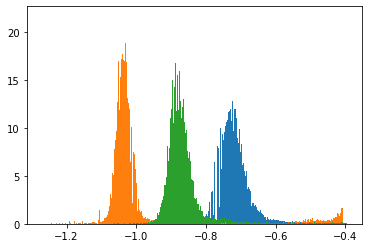

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,10))

time = (np.arange(result.shape[0])*1/(1e6))*1e3
ax1.plot(time, phase_data)
#plt.plot(time[readout.trig], result[readout.trig],"o")
ax1.set_xlim([0,500])
ax1.grid()
ax1.set_title('Raw Phase')
ax1.set_ylabel('Phase (radians)')
ax2.plot(time, result)
ax2.set_title('Optimal Filtered')
ax2.set_ylabel('Phase (radians)')
ax2.set_xlabel('Time (ms)')
ax2.grid()


In [14]:
plot_psd(phase_data, fres=1e2)

(array([1504.95636372, 2139.72074519]),
 1822.3385544552827,
 array([405.9, 663.1, 978. ]),
 array([-1.03564258, -0.86474061, -0.71757188]),
 array([121.30623651, 277.22684026, 223.56699848]),
 array([3.34607693, 2.39190404, 4.37452758]))

In [14]:
plot_psd(result)

In [14]:
readout = MKIDReadout()
readout_raw = MKIDReadout()
readout.trigger(result, fs = 1e6, threshold=-0.15, deadtime=30)
readout_raw.trigger(phase_data, fs = 1e6, threshold=-0.5, deadtime=25)


In [15]:
(readout_raw.trig>0).sum()

(-0.7175718770157592,
 0.052097982882860196,
 -0.98971554979207,
 0.15346872298200853,
 -0.8647406142017101,
 0.06460237547032432)

In [15]:
readout.record_energies(result)
readout_raw.record_energies(phase_data)

In [15]:
#readout.plot_triggers(result, fs=1e6, energies=True)

In [15]:
readout_raw.plot_triggers(phase_data-phase_dark.mean(), fs=1e6, energies=True)
plt.xlim([55000,65000])

In [16]:
readout.plot_energies()

NameError: name 'readout' is not defined

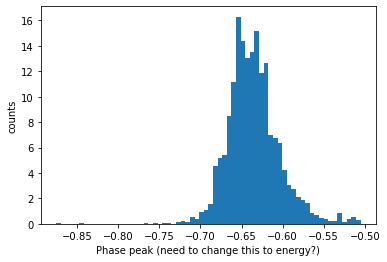

In [38]:
readout_raw.plot_energies()

3.974284403048757

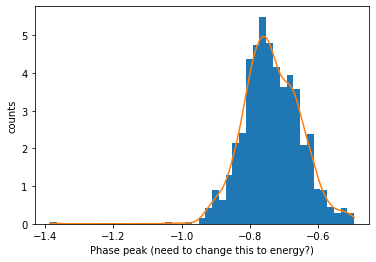

In [43]:
compute_r(readout.photon_energies-phase_dark.mean(), plot=True)


15.453975822558649

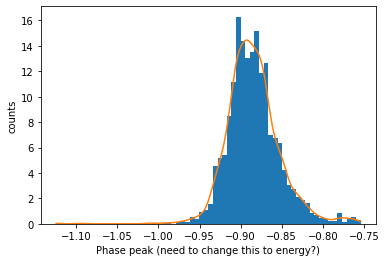

In [39]:
readout.photon_energies.shape

21.03317120852546

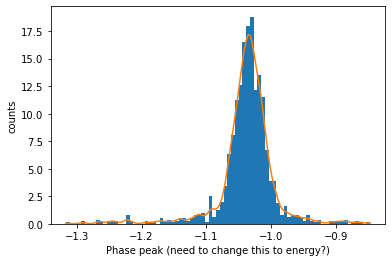

In [42]:
compute_r(readout_raw.photon_energies-phase_dark.mean(), plot=True)

In [104]:
readout_raw.photon_energies.shape

(1368,)

In [79]:
readout_raw.photon_energies.mean()

-0.6949775813884922

In [76]:
readout.photon_energies.shape

(1360,)